Done loading the whole data
Successful for a given cid
Done transferring data
Epoch 1/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0302
Epoch 2/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0248
Epoch 3/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0276
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0261
Epoch 5/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0246
Epoch 6/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0234
Epoch 7/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0215
Epoch 8/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0224
Epoch 9/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0211
Epoch 10/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0221
Epoch 11/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0201
Epoch 12/100
112/1

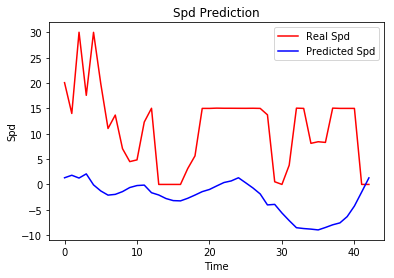

Done plots


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
from sklearn.metrics import mean_squared_error

import random

def get_data():
#     path = 'BudgetCalculator%2Fadx_funnel_combo2018-05-03_v3.csv'
    path = 'all_mdf3_2018-05-03.csv'
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    return df

def get_cid_data(df, CID):
    """
    :type df: pandas.dataframe
    :type CID: int
    :rtype: pandas.dataframe
    get data for a specific cid w/ data sorted in asecnding order
    """
    df = df[df.cid==CID].sort_values(by='date',ascending=True)
#     columns_list = [col for col in df.columns
#                     if col not in [
#                     'bid','cid','date','campaign_type',
#                     'is_lower_funnel', 'spd'
#                     ]]
    columns_list = [col for col in df.columns
                    if col not in [
                    'bid','cid','date','campaign_type',
                    'is_lower_funnel', 'spd', 'objective',
                    'roi_goal','price_model'
                    ]]
    y = 'spd'

    df = df[[y] + columns_list]
    # make sure spd'd be the first col in df
    return df

def data_transoformation(df):
    train_test_split_rat = 0.75
    train_idx = int(train_test_split_rat*df.shape[0])
    training_set = df.iloc[:train_idx,:].values

    # feature sacling
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)
    assert training_set_scaled.shape == training_set.shape

    # creating a data structure w/ k previous timesteps
    D = len(df.columns)
    k = 15
    X_train, y_train = [], []
    for i in range(k, len(training_set)):
        X_train.append(training_set_scaled[i-k:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshaping
    X_train = np.reshape(
        X_train,
        (X_train.shape[0], X_train.shape[1], D)
    )

    # getting the real spd
    dataset_test = df.iloc[train_idx:, :].values
    real_spd = dataset_test[:, 0:1]

    # getting the predicted spd inputs
    dataset_total = df.iloc[:,:].values
    inputs = dataset_total[len(dataset_total)-len(dataset_test)-k:, :]
    inputs = inputs.reshape(-1, D)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(k, inputs.shape[0]):
        X_test.append(inputs[i-k:i,:])
    X_test = np.array(X_test)
    X_test = np.reshape(
        X_test,
        (X_test.shape[0], X_test.shape[1], D)
    )

    return X_train, y_train, X_test, real_spd, sc, train_idx

def model_train(X_train, y_train):
    # Initializing the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some dropout reg
    # w/ dropout rate: p
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    p = 0.2
    regressor.add(Dropout(p))

    # Adding a 2nd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 3rd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 4th LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=False,
        )
    )
    regressor.add(Dropout(p))

    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the training set
    regressor.fit(X_train, y_train, epochs=100, batch_size=8)
    return regressor

def model_test(X_test, regressor):
    predicted_spd = regressor.predict(X_test)
    return predicted_spd



def cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df):
    D = 17
#     train_idx = int(0.9*df.shape[0])
#     dummy = np.random.randn(len(X_test), D-1)
    dummy = np.random.randn(len(X_test), D-1)
#     print(df.shape, X_train.shape, X_test.shape)
    print(dummy.shape)
    predicted_spd = np.concatenate((predicted_spd, dummy), axis=1)
    print(predicted_spd.shape)
    predicted_spd = sc.inverse_transform(predicted_spd)
    print(predicted_spd.shape)
    predicted_spd_list = [ele for ele in predicted_spd[:,0]]
    real_spd_list = [ele for ele in real_spd.reshape(-1)]
    df_comp = pd.DataFrame(data = df.iloc[train_idx:, :1].values, columns=['real_spd'])
    df_comp['prediction spd'] = predicted_spd_list
    return df_comp, predicted_spd

def model_metrics(real_spd, predicted_spd):
    rmse = math.sqrt(mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("MSE:", mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("RMSE:", rmse)

def vis_plot(real_spd, predicted_spd):
    plt.plot(real_spd, color = 'red', label = 'Real Spd')
    plt.plot(predicted_spd[:,0:1], color = 'blue', label = 'Predicted Spd')
    plt.title('Spd Prediction')
    plt.xlabel('Time')
    plt.ylabel('Spd')
    plt.legend()
    plt.show()

def main():

    df = get_data()
    print('Done loading the whole data')

    df = get_cid_data(df, 3119)
    print('Successful for a given cid')

    X_train, y_train, X_test, real_spd, sc, train_idx = data_transoformation(df)
    print('Done transferring data')

    regressor = model_train(X_train, y_train)
    print('Done training')

    predicted_spd = model_test(X_test, regressor)
    print('Done predictions')

    df_comp, predicted_spd = cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df)
    print('Done comparasion table')
    print(df_comp)

    model_metrics(real_spd, predicted_spd)
    print('Done Metrics')

    vis_plot(real_spd, predicted_spd)
    print('Done plots')

if __name__ == '__main__':
    main()

Done loading the whole data
Successful for a given cid
Done transferring data
Epoch 1/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0710
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0414
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0449
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0352
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0337
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0339
Epoch 7/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0336
Epoch 8/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0331
Epoch 9/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0324
Epoch 10/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0307
Epoch 11/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0328
Epoch 12/100
110/1

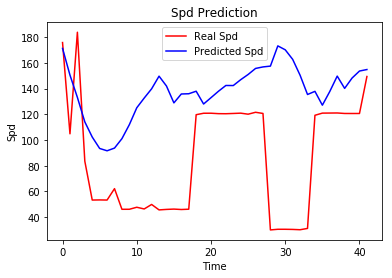

Done plots


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
from sklearn.metrics import mean_squared_error

import random

def get_data():
#     path = 'BudgetCalculator%2Fadx_funnel_combo2018-05-03_v3.csv'
#     path = 'all_mdf2_2018-05-03.csv'
    path = 'all_mdf3_2018-05-03.csv'
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    return df

def get_cid_data(df, CID):
    """
    :type df: pandas.dataframe
    :type CID: int
    :rtype: pandas.dataframe
    get data for a specific cid w/ data sorted in asecnding order
    """
    df = df[df.cid==CID].sort_values(by='date',ascending=True)
#     columns_list = [col for col in df.columns
#                     if col not in [
#                     'bid','cid','date','campaign_type',
#                     'is_lower_funnel', 'spd'
#                     ]]
    columns_list = [col for col in df.columns
                    if col not in [
                    'bid','cid','date','campaign_type',
                    'is_lower_funnel', 'spd', 'objective',
                    'roi_goal','price_model'
                    ]]
    y = 'spd'

    df = df[[y] + columns_list]
    # make sure spd'd be the first col in df
    return df

def data_transoformation(df):
    train_test_split_rat = 0.75
    train_idx = int(train_test_split_rat*df.shape[0])
    training_set = df.iloc[:train_idx,:].values

    # feature sacling
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)
    assert training_set_scaled.shape == training_set.shape

    # creating a data structure w/ k previous timesteps
    D = len(df.columns)
    k = 15
    X_train, y_train = [], []
    for i in range(k, len(training_set)):
        X_train.append(training_set_scaled[i-k:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshaping
    X_train = np.reshape(
        X_train,
        (X_train.shape[0], X_train.shape[1], D)
    )

    # getting the real spd
    dataset_test = df.iloc[train_idx:, :].values
    real_spd = dataset_test[:, 0:1]

    # getting the predicted spd inputs
    dataset_total = df.iloc[:,:].values
    inputs = dataset_total[len(dataset_total)-len(dataset_test)-k:, :]
    inputs = inputs.reshape(-1, D)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(k, inputs.shape[0]):
        X_test.append(inputs[i-k:i,:])
    X_test = np.array(X_test)
    X_test = np.reshape(
        X_test,
        (X_test.shape[0], X_test.shape[1], D)
    )

    return X_train, y_train, X_test, real_spd, sc, train_idx

def model_train(X_train, y_train):
    # Initializing the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some dropout reg
    # w/ dropout rate: p
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    p = 0.2
    regressor.add(Dropout(p))

    # Adding a 2nd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 3rd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 4th LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=False,
        )
    )
    regressor.add(Dropout(p))

    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the training set
    regressor.fit(X_train, y_train, epochs=100, batch_size=8)
    return regressor

def model_test(X_test, regressor):
    predicted_spd = regressor.predict(X_test)
    return predicted_spd



def cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df):
    D = 17
#     train_idx = int(0.9*df.shape[0])
#     dummy = np.random.randn(len(X_test), D-1)
    dummy = np.random.randn(len(X_test), D-1)
#     print(df.shape, X_train.shape, X_test.shape)
    print(dummy.shape)
    predicted_spd = np.concatenate((predicted_spd, dummy), axis=1)
    print(predicted_spd.shape)
    predicted_spd = sc.inverse_transform(predicted_spd)
    print(predicted_spd.shape)
    predicted_spd_list = [ele for ele in predicted_spd[:,0]]
    real_spd_list = [ele for ele in real_spd.reshape(-1)]
    df_comp = pd.DataFrame(data = df.iloc[train_idx:, :1].values, columns=['real_spd'])
    df_comp['prediction spd'] = predicted_spd_list
    return df_comp, predicted_spd

def model_metrics(real_spd, predicted_spd):
    rmse = math.sqrt(mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("MSE:", mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("RMSE:", rmse)

def vis_plot(real_spd, predicted_spd):
    plt.plot(real_spd, color = 'red', label = 'Real Spd')
    plt.plot(predicted_spd[:,0:1], color = 'blue', label = 'Predicted Spd')
    plt.title('Spd Prediction')
    plt.xlabel('Time')
    plt.ylabel('Spd')
    plt.legend()
    plt.show()

def main():

    df = get_data()
    print('Done loading the whole data')

    df = get_cid_data(df, 3289)
    print('Successful for a given cid')

    X_train, y_train, X_test, real_spd, sc, train_idx = data_transoformation(df)
    print('Done transferring data')

    regressor = model_train(X_train, y_train)
    print('Done training')

    predicted_spd = model_test(X_test, regressor)
    print('Done predictions')

    df_comp, predicted_spd = cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df)
    print('Done comparasion table')
    print(df_comp)

    model_metrics(real_spd, predicted_spd)
    print('Done Metrics')

    vis_plot(real_spd, predicted_spd)
    print('Done plots')

if __name__ == '__main__':
    main()

Done loading the whole data
Successful for a given cid
Done transferring data
Epoch 1/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0998
Epoch 2/100
86/86 [==============================] - 1s 6ms/step - loss: 0.0378
Epoch 3/100
86/86 [==============================] - 1s 6ms/step - loss: 0.0282
Epoch 4/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 5/100
86/86 [==============================] - 1s 6ms/step - loss: 0.0201
Epoch 6/100
86/86 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 7/100
86/86 [==============================] - 1s 7ms/step - loss: 0.0186
Epoch 8/100
86/86 [==============================] - 1s 7ms/step - loss: 0.0211
Epoch 9/100
86/86 [==============================] - 1s 7ms/step - loss: 0.0205
Epoch 10/100
86/86 [==============================] - 1s 7ms/step - loss: 0.0186
Epoch 11/100
86/86 [==============================] - 1s 7ms/step - loss: 0.0230
Epoch 12/100
86/86 [====================

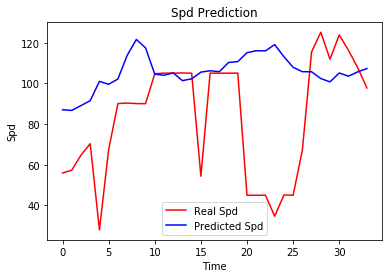

Done plots


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
from sklearn.metrics import mean_squared_error

import random

def get_data():
#     path = 'BudgetCalculator%2Fadx_funnel_combo2018-05-03_v3.csv'
#     path = 'all_mdf2_2018-05-03.csv'
    path = 'all_mdf3_2018-05-03.csv'
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    return df

def get_cid_data(df, CID):
    """
    :type df: pandas.dataframe
    :type CID: int
    :rtype: pandas.dataframe
    get data for a specific cid w/ data sorted in asecnding order
    """
    df = df[df.cid==CID].sort_values(by='date',ascending=True)
#     columns_list = [col for col in df.columns
#                     if col not in [
#                     'bid','cid','date','campaign_type',
#                     'is_lower_funnel', 'spd'
#                     ]]
    columns_list = [col for col in df.columns
                    if col not in [
                    'bid','cid','date','campaign_type',
                    'is_lower_funnel', 'spd', 'objective',
                    'roi_goal','price_model'
                    ]]
    y = 'spd'

    df = df[[y] + columns_list]
    # make sure spd'd be the first col in df
    return df

def data_transoformation(df):
    train_test_split_rat = 0.75
    train_idx = int(train_test_split_rat*df.shape[0])
    training_set = df.iloc[:train_idx,:].values

    # feature sacling
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)
    assert training_set_scaled.shape == training_set.shape

    # creating a data structure w/ k previous timesteps
    D = len(df.columns)
    k = 15
    X_train, y_train = [], []
    for i in range(k, len(training_set)):
        X_train.append(training_set_scaled[i-k:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshaping
    X_train = np.reshape(
        X_train,
        (X_train.shape[0], X_train.shape[1], D)
    )

    # getting the real spd
    dataset_test = df.iloc[train_idx:, :].values
    real_spd = dataset_test[:, 0:1]

    # getting the predicted spd inputs
    dataset_total = df.iloc[:,:].values
    inputs = dataset_total[len(dataset_total)-len(dataset_test)-k:, :]
    inputs = inputs.reshape(-1, D)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(k, inputs.shape[0]):
        X_test.append(inputs[i-k:i,:])
    X_test = np.array(X_test)
    X_test = np.reshape(
        X_test,
        (X_test.shape[0], X_test.shape[1], D)
    )

    return X_train, y_train, X_test, real_spd, sc, train_idx

def model_train(X_train, y_train):
    # Initializing the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some dropout reg
    # w/ dropout rate: p
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    p = 0.2
    regressor.add(Dropout(p))

    # Adding a 2nd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 3rd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 4th LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=False,
        )
    )
    regressor.add(Dropout(p))

    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the training set
    regressor.fit(X_train, y_train, epochs=100, batch_size=8)
    return regressor

def model_test(X_test, regressor):
    predicted_spd = regressor.predict(X_test)
    return predicted_spd



def cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df):
    D = 17
#     train_idx = int(0.9*df.shape[0])
#     dummy = np.random.randn(len(X_test), D-1)
    dummy = np.random.randn(len(X_test), D-1)
#     print(df.shape, X_train.shape, X_test.shape)
    print(dummy.shape)
    predicted_spd = np.concatenate((predicted_spd, dummy), axis=1)
    print(predicted_spd.shape)
    predicted_spd = sc.inverse_transform(predicted_spd)
    print(predicted_spd.shape)
    predicted_spd_list = [ele for ele in predicted_spd[:,0]]
    real_spd_list = [ele for ele in real_spd.reshape(-1)]
    df_comp = pd.DataFrame(data = df.iloc[train_idx:, :1].values, columns=['real_spd'])
    df_comp['prediction spd'] = predicted_spd_list
    return df_comp, predicted_spd

def model_metrics(real_spd, predicted_spd):
    rmse = math.sqrt(mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("MSE:", mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("RMSE:", rmse)

def vis_plot(real_spd, predicted_spd):
    plt.plot(real_spd, color = 'red', label = 'Real Spd')
    plt.plot(predicted_spd[:,0:1], color = 'blue', label = 'Predicted Spd')
    plt.title('Spd Prediction')
    plt.xlabel('Time')
    plt.ylabel('Spd')
    plt.legend()
    plt.show()

def main():

    df = get_data()
    print('Done loading the whole data')

    df = get_cid_data(df, 3292)
    print('Successful for a given cid')

    X_train, y_train, X_test, real_spd, sc, train_idx = data_transoformation(df)
    print('Done transferring data')

    regressor = model_train(X_train, y_train)
    print('Done training')

    predicted_spd = model_test(X_test, regressor)
    print('Done predictions')

    df_comp, predicted_spd = cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df)
    print('Done comparasion table')
    print(df_comp)

    model_metrics(real_spd, predicted_spd)
    print('Done Metrics')

    vis_plot(real_spd, predicted_spd)
    print('Done plots')

if __name__ == '__main__':
    main()

Done loading the whole data
Successful for a given cid
Done transferring data
Epoch 1/100
122/122 [==============================] - 1s 8ms/step - loss: 0.1012
Epoch 2/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0650
Epoch 3/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0576
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0545
Epoch 5/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0590
Epoch 6/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0509
Epoch 7/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0472
Epoch 8/100
122/122 [==============================] - 1s 7ms/step - loss: 0.0436
Epoch 9/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0442
Epoch 10/100
122/122 [==============================] - 1s 6ms/step - loss: 0.0414
Epoch 11/100
122/122 [==============================] - 1s 7ms/step - loss: 0.0398
Epoch 12/100
122/1

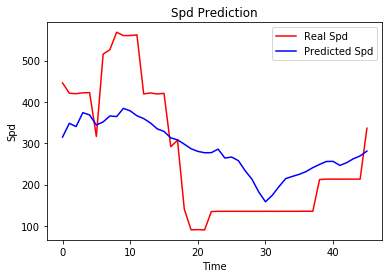

Done plots


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
from sklearn.metrics import mean_squared_error

import random

def get_data():
#     path = 'BudgetCalculator%2Fadx_funnel_combo2018-05-03_v3.csv'
#     path = 'all_mdf2_2018-05-03.csv'
    path = 'all_mdf3_2018-05-03.csv'
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    return df

def get_cid_data(df, CID):
    """
    :type df: pandas.dataframe
    :type CID: int
    :rtype: pandas.dataframe
    get data for a specific cid w/ data sorted in asecnding order
    """
    df = df[df.cid==CID].sort_values(by='date',ascending=True)
#     columns_list = [col for col in df.columns
#                     if col not in [
#                     'bid','cid','date','campaign_type',
#                     'is_lower_funnel', 'spd'
#                     ]]
    columns_list = [col for col in df.columns
                    if col not in [
                    'bid','cid','date','campaign_type',
                    'is_lower_funnel', 'spd', 'objective',
                    'roi_goal','price_model'
                    ]]
    y = 'spd'

    df = df[[y] + columns_list]
    # make sure spd'd be the first col in df
    return df

def data_transoformation(df):
    train_test_split_rat = 0.75
    train_idx = int(train_test_split_rat*df.shape[0])
    training_set = df.iloc[:train_idx,:].values

    # feature sacling
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)
    assert training_set_scaled.shape == training_set.shape

    # creating a data structure w/ k previous timesteps
    D = len(df.columns)
    k = 15
    X_train, y_train = [], []
    for i in range(k, len(training_set)):
        X_train.append(training_set_scaled[i-k:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshaping
    X_train = np.reshape(
        X_train,
        (X_train.shape[0], X_train.shape[1], D)
    )

    # getting the real spd
    dataset_test = df.iloc[train_idx:, :].values
    real_spd = dataset_test[:, 0:1]

    # getting the predicted spd inputs
    dataset_total = df.iloc[:,:].values
    inputs = dataset_total[len(dataset_total)-len(dataset_test)-k:, :]
    inputs = inputs.reshape(-1, D)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(k, inputs.shape[0]):
        X_test.append(inputs[i-k:i,:])
    X_test = np.array(X_test)
    X_test = np.reshape(
        X_test,
        (X_test.shape[0], X_test.shape[1], D)
    )

    return X_train, y_train, X_test, real_spd, sc, train_idx

def model_train(X_train, y_train):
    # Initializing the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some dropout reg
    # w/ dropout rate: p
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    p = 0.2
    regressor.add(Dropout(p))

    # Adding a 2nd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 3rd LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=True,
        )
    )
    regressor.add(Dropout(p))

    # Adding a 4th LSTM layer and some dropout reg
    regressor.add(
        LSTM(
            units=50,
            return_sequences=False,
        )
    )
    regressor.add(Dropout(p))

    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the training set
    regressor.fit(X_train, y_train, epochs=100, batch_size=8)
    return regressor

def model_test(X_test, regressor):
    predicted_spd = regressor.predict(X_test)
    return predicted_spd



def cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df):
    D = 17
#     train_idx = int(0.9*df.shape[0])
#     dummy = np.random.randn(len(X_test), D-1)
    dummy = np.random.randn(len(X_test), D-1)
#     print(df.shape, X_train.shape, X_test.shape)
    print(dummy.shape)
    predicted_spd = np.concatenate((predicted_spd, dummy), axis=1)
    print(predicted_spd.shape)
    predicted_spd = sc.inverse_transform(predicted_spd)
    print(predicted_spd.shape)
    predicted_spd_list = [ele for ele in predicted_spd[:,0]]
    real_spd_list = [ele for ele in real_spd.reshape(-1)]
    df_comp = pd.DataFrame(data = df.iloc[train_idx:, :1].values, columns=['real_spd'])
    df_comp['prediction spd'] = predicted_spd_list
    return df_comp, predicted_spd

def model_metrics(real_spd, predicted_spd):
    rmse = math.sqrt(mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("MSE:", mean_squared_error(real_spd, predicted_spd[:,0:1]))
    print("RMSE:", rmse)

def vis_plot(real_spd, predicted_spd):
    plt.plot(real_spd, color = 'red', label = 'Real Spd')
    plt.plot(predicted_spd[:,0:1], color = 'blue', label = 'Predicted Spd')
    plt.title('Spd Prediction')
    plt.xlabel('Time')
    plt.ylabel('Spd')
    plt.legend()
    plt.show()

def main():

    df = get_data()
    print('Done loading the whole data')

    df = get_cid_data(df, 3293)
    print('Successful for a given cid')

    X_train, y_train, X_test, real_spd, sc, train_idx = data_transoformation(df)
    print('Done transferring data')

    regressor = model_train(X_train, y_train)
    print('Done training')

    predicted_spd = model_test(X_test, regressor)
    print('Done predictions')

    df_comp, predicted_spd = cmp_table(predicted_spd, real_spd, sc, X_test, train_idx, df)
    print('Done comparasion table')
    print(df_comp)

    model_metrics(real_spd, predicted_spd)
    print('Done Metrics')

    vis_plot(real_spd, predicted_spd)
    print('Done plots')

if __name__ == '__main__':
    main()